In [ ]:
#@title 1) Install required packages (run once)
!pip install -q pandas scikit-learn xgboost shap pytesseract pillow joblib gradio gtts soundfile
# Tesseract OCR (system package) for pytesseract to work in Colab
!apt-get -qq update && apt-get -qq install -y tesseract-ocr
print("Installed required packages.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 4.4 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Installed required packages.


In [ ]:
#@title 2) Imports and global settings
import os, io, json
import numpy as np
import pandas as pd
from PIL import Image

import pytesseract
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import xgboost as xgb
import shap
import joblib
from datetime import datetime

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print("Imports done.")

Imports done.


In [ ]:
#@title 3) Upload project/spec picture(s) and extract OCR text
from google.colab import files

print("Upload 1 or more picture files that contain project/spec info (optional). Close dialog if you don't have one.")
uploaded = files.upload()

project_text = ""
if uploaded:
    for fname in uploaded.keys():
        img = Image.open(fname).convert("RGB")
        text = pytesseract.image_to_string(img)
        print(f"\n--- OCR from {fname} ---\n")
        print(text[:2000])  # print first 2000 chars to avoid spamming
        project_text += f"\n\n=== {fname} ===\n" + text
    print("\nOCR extraction complete. Stored in variable `project_text`.")
else:
    print("No files uploaded. `project_text` will be empty.")

Upload 1 or more picture files that contain project/spec info (optional). Close dialog if you don't have one.


No files uploaded. `project_text` will be empty.


In [ ]:
#@title Create a sample loan_data.csv file in Colab

import pandas as pd

data = {
    "Gender": ["Male","Female","Male","Male","Female","Male","Female","Male","Male","Female"],
    "Married": ["Yes","No","Yes","No","Yes","No","No","Yes","No","Yes"],
    "Dependents": ["1","0","2","0","1","3+","0","2","0","1"],
    "Education": ["Graduate","Graduate","Not Graduate","Graduate","Graduate","Graduate","Not Graduate","Graduate","Graduate","Not Graduate"],
    "ApplicantIncome": [5000,3000,4000,6000,2500,7000,1500,4000,3500,4500],
    "CoapplicantIncome": [0,1500,2500,0,2000,0,1800,2000,0,1200],
    "LoanAmount": [150,120,200,180,100,300,90,110,80,140],
    "Loan_Amount_Term": [360,360,360,360,180,360,360,120,360,360],
    "Credit_History": [1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0],
    "Property_Area": ["Urban","Rural","Semiurban","Urban","Semiurban","Urban","Rural","Semiurban","Rural","Urban"],
    "Loan_Status": ["Y","N","N","Y","Y","Y","N","Y","Y","N"]
}

df_sample = pd.DataFrame(data)
df_sample.to_csv("loan_data.csv", index=False)

print("✅ Created sample loan_data.csv with shape:", df_sample.shape)
df_sample.head()


✅ Created sample loan_data.csv with shape: (10, 11)


,Gender,Married,Dependents,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,1,Graduate,5000,0,150,360,1.0,Urban,Y
1,Female,No,0,Graduate,3000,1500,120,360,1.0,Rural,N
2,Male,Yes,2,Not Graduate,4000,2500,200,360,0.0,Semiurban,N
3,Male,No,0,Graduate,6000,0,180,360,1.0,Urban,Y
4,Female,Yes,1,Graduate,2500,2000,100,180,1.0,Semiurban,Y


from matplotlib import pyplot as plt
_df_0['ApplicantIncome'].plot(kind='hist', bins=20, title='ApplicantIncome')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['CoapplicantIncome'].plot(kind='hist', bins=20, title='CoapplicantIncome')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['LoanAmount'].plot(kind='hist', bins=20, title='LoanAmount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Loan_Amount_Term'].plot(kind='hist', bins=20, title='Loan_Amount_Term')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('Married').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('Dependents').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('Education').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='ApplicantIncome', y='CoapplicantIncome', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='CoapplicantIncome', y='LoanAmount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='LoanAmount', y='Loan_Amount_Term', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='Loan_Amount_Term', y='Credit_History', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_12['ApplicantIncome'].plot(kind='line', figsize=(8, 4), title='ApplicantIncome')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['CoapplicantIncome'].plot(kind='line', figsize=(8, 4), title='CoapplicantIncome')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['LoanAmount'].plot(kind='line', figsize=(8, 4), title='LoanAmount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Loan_Amount_Term'].plot(kind='line', figsize=(8, 4), title='Loan_Amount_Term')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Married'].value_counts()
    for x_label, grp in _df_16.groupby('Gender')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Gender')
_ = plt.ylabel('Married')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Dependents'].value_counts()
    for x_label, grp in _df_17.groupby('Married')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Married')
_ = plt.ylabel('Dependents')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Education'].value_counts()
    for x_label, grp in _df_18.groupby('Dependents')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Dependents')
_ = plt.ylabel('Education')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Property_Area'].value_counts()
    for x_label, grp in _df_19.groupby('Education')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Education')
_ = plt.ylabel('Property_Area')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='ApplicantIncome', y='Gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['Married'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='ApplicantIncome', y='Married', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['Dependents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='ApplicantIncome', y='Dependents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_23['Education'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_23, x='ApplicantIncome', y='Education', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
import pandas as pd

df = pd.read_csv("loan_data.csv")
print("Data loaded successfully!")
print("Shape:", df.shape)
df.head()

Data loaded successfully!
Shape: (10, 11)


,Gender,Married,Dependents,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,1,Graduate,5000,0,150,360,1.0,Urban,Y
1,Female,No,0,Graduate,3000,1500,120,360,1.0,Rural,N
2,Male,Yes,2,Not Graduate,4000,2500,200,360,0.0,Semiurban,N
3,Male,No,0,Graduate,6000,0,180,360,1.0,Urban,Y
4,Female,Yes,1,Graduate,2500,2000,100,180,1.0,Semiurban,Y


from matplotlib import pyplot as plt
_df_24['ApplicantIncome'].plot(kind='hist', bins=20, title='ApplicantIncome')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_25['CoapplicantIncome'].plot(kind='hist', bins=20, title='CoapplicantIncome')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_26['LoanAmount'].plot(kind='hist', bins=20, title='LoanAmount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_27['Loan_Amount_Term'].plot(kind='hist', bins=20, title='Loan_Amount_Term')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_28.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_29.groupby('Married').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_30.groupby('Dependents').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_31.groupby('Education').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_32.plot(kind='scatter', x='ApplicantIncome', y='CoapplicantIncome', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_33.plot(kind='scatter', x='CoapplicantIncome', y='LoanAmount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_34.plot(kind='scatter', x='LoanAmount', y='Loan_Amount_Term', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_35.plot(kind='scatter', x='Loan_Amount_Term', y='Credit_History', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_36['ApplicantIncome'].plot(kind='line', figsize=(8, 4), title='ApplicantIncome')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_37['CoapplicantIncome'].plot(kind='line', figsize=(8, 4), title='CoapplicantIncome')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_38['LoanAmount'].plot(kind='line', figsize=(8, 4), title='LoanAmount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_39['Loan_Amount_Term'].plot(kind='line', figsize=(8, 4), title='Loan_Amount_Term')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Married'].value_counts()
    for x_label, grp in _df_40.groupby('Gender')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Gender')
_ = plt.ylabel('Married')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Dependents'].value_counts()
    for x_label, grp in _df_41.groupby('Married')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Married')
_ = plt.ylabel('Dependents')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Education'].value_counts()
    for x_label, grp in _df_42.groupby('Dependents')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Dependents')
_ = plt.ylabel('Education')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Property_Area'].value_counts()
    for x_label, grp in _df_43.groupby('Education')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Education')
_ = plt.ylabel('Property_Area')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_44['Gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_44, x='ApplicantIncome', y='Gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_45['Married'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_45, x='ApplicantIncome', y='Married', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_46['Dependents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_46, x='ApplicantIncome', y='Dependents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_47['Education'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_47, x='ApplicantIncome', y='Education', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
#@title 5) EDA: info, missing values, basic distributions
print("Shape:", df.shape)
print("\nColumns and dtypes:")
print(df.dtypes)
print("\nMissing values by column:")
print(df.isnull().sum())

print("\nSample data:")
df.head()

Shape: (10, 11)

Columns and dtypes:
Gender                object
Married               object
Dependents            object
Education             object
ApplicantIncome        int64
CoapplicantIncome      int64
LoanAmount             int64
Loan_Amount_Term       int64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

Missing values by column:
Gender               0
Married              0
Dependents           0
Education            0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

Sample data:


,Gender,Married,Dependents,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,1,Graduate,5000,0,150,360,1.0,Urban,Y
1,Female,No,0,Graduate,3000,1500,120,360,1.0,Rural,N
2,Male,Yes,2,Not Graduate,4000,2500,200,360,0.0,Semiurban,N
3,Male,No,0,Graduate,6000,0,180,360,1.0,Urban,Y
4,Female,Yes,1,Graduate,2500,2000,100,180,1.0,Semiurban,Y


from matplotlib import pyplot as plt
_df_48['ApplicantIncome'].plot(kind='hist', bins=20, title='ApplicantIncome')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_49['CoapplicantIncome'].plot(kind='hist', bins=20, title='CoapplicantIncome')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_50['LoanAmount'].plot(kind='hist', bins=20, title='LoanAmount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_51['Loan_Amount_Term'].plot(kind='hist', bins=20, title='Loan_Amount_Term')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_52.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_53.groupby('Married').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_54.groupby('Dependents').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_55.groupby('Education').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_56.plot(kind='scatter', x='ApplicantIncome', y='CoapplicantIncome', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_57.plot(kind='scatter', x='CoapplicantIncome', y='LoanAmount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_58.plot(kind='scatter', x='LoanAmount', y='Loan_Amount_Term', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_59.plot(kind='scatter', x='Loan_Amount_Term', y='Credit_History', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_60['ApplicantIncome'].plot(kind='line', figsize=(8, 4), title='ApplicantIncome')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_61['CoapplicantIncome'].plot(kind='line', figsize=(8, 4), title='CoapplicantIncome')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_62['LoanAmount'].plot(kind='line', figsize=(8, 4), title='LoanAmount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_63['Loan_Amount_Term'].plot(kind='line', figsize=(8, 4), title='Loan_Amount_Term')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Married'].value_counts()
    for x_label, grp in _df_64.groupby('Gender')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Gender')
_ = plt.ylabel('Married')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Dependents'].value_counts()
    for x_label, grp in _df_65.groupby('Married')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Married')
_ = plt.ylabel('Dependents')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Education'].value_counts()
    for x_label, grp in _df_66.groupby('Dependents')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Dependents')
_ = plt.ylabel('Education')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Property_Area'].value_counts()
    for x_label, grp in _df_67.groupby('Education')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Education')
_ = plt.ylabel('Property_Area')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_68['Gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_68, x='ApplicantIncome', y='Gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_69['Married'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_69, x='ApplicantIncome', y='Married', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_70['Dependents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_70, x='ApplicantIncome', y='Dependents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_71['Education'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_71, x='ApplicantIncome', y='Education', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
#@title 6) Data Cleaning and Preprocessing
import numpy as np

# Check missing values
print("Missing values before cleaning:\n", df.isnull().sum())

# Fill missing categorical values with mode (most frequent)
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']:
    if col in df.columns:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Fill missing numerical values with mean or median
for col in ['LoanAmount', 'Loan_Amount_Term']:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

print("\n✅ Missing values after cleaning:\n", df.isnull().sum())

# Convert categorical values into numeric
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

for col in df.select_dtypes(include=['object']).columns:
    df[col] = encoder.fit_transform(df[col])

print("\n✅ Encoded categorical columns successfully.")
print("Updated dataset shape:", df.shape)

df.head()

Missing values before cleaning:
 Gender               0
Married              0
Dependents           0
Education            0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

✅ Missing values after cleaning:
 Gender               0
Married              0
Dependents           0
Education            0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

✅ Encoded categorical columns successfully.
Updated dataset shape: (10, 11)


/tmp/ipython-input-2437911068.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-2437911068.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

,Gender,Married,Dependents,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,1,1,0,5000,0,150,360,1.0,2,1
1,0,0,0,0,3000,1500,120,360,1.0,0,0
2,1,1,2,1,4000,2500,200,360,0.0,1,0
3,1,0,0,0,6000,0,180,360,1.0,2,1
4,0,1,1,0,2500,2000,100,180,1.0,1,1


from matplotlib import pyplot as plt
_df_72['Gender'].plot(kind='hist', bins=20, title='Gender')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_73['Married'].plot(kind='hist', bins=20, title='Married')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_74['Dependents'].plot(kind='hist', bins=20, title='Dependents')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_75['Education'].plot(kind='hist', bins=20, title='Education')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_76.plot(kind='scatter', x='Gender', y='Married', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_77.plot(kind='scatter', x='Married', y='Dependents', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_78.plot(kind='scatter', x='Dependents', y='Education', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_79.plot(kind='scatter', x='Education', y='ApplicantIncome', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_80['Gender'].plot(kind='line', figsize=(8, 4), title='Gender')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_81['Married'].plot(kind='line', figsize=(8, 4), title='Married')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_82['Dependents'].plot(kind='line', figsize=(8, 4), title='Dependents')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_83['Education'].plot(kind='line', figsize=(8, 4), title='Education')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
#@title 7) Model Training and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define features (X) and target (y)
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize model
model = RandomForestClassifier(random_state=42)

# Train model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model
print("✅ Model trained successfully!\n")
print("Accuracy:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Model trained successfully!

Accuracy: 50.0 %

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

Confusion Matrix:
 [[0 1]
 [0 1]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#@title A) Install required libraries for Gradio, STT, and TTS
!pip install -q gradio==3.45.0 SpeechRecognition pydub google-cloud-speech
!apt-get -qq install -y ffmpeg
!pip install -q gtts

print("Installed audio & Gradio dependencies.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 135.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 145.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 12.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.48.0 requires websockets<15.1.0,>=13.0.0, but you have websockets 11.0.3 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which

In [ ]:
#@title B) Reload raw CSV, build preprocessing pipeline, train RandomForest pipeline
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import joblib

# Load raw CSV (make sure loan_data.csv exists in Files)
csv_name = "loan_data.csv"
df_raw = pd.read_csv(csv_name)
print("Loaded", csv_name, "shape:", df_raw.shape)
display(df_raw.head())

# Target column - ensure consistent name
TARGET = None
for cand in ["Loan_Status","loan_status","LoanStatus","loanStatus"]:
    if cand in df_raw.columns:
        TARGET = cand
        break
if TARGET is None:
    raise ValueError("Target column (Loan_Status) not found in CSV. Rename it to Loan_Status.")

# Prepare X and y (use raw values)
X = df_raw.drop(columns=[TARGET])
y = df_raw[TARGET].map({"Y":1,"N":0}) if df_raw[TARGET].dtype == object else df_raw[TARGET]

# Choose numeric and categorical columns automatically
numeric_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()

# Remove id-like columns from features if present
identifier_cols = [c for c in numeric_cols if c.lower().endswith("id")]
for c in identifier_cols:
    numeric_cols.remove(c)

print("Numeric cols:", numeric_cols)
print("Categorical cols:", cat_cols)

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, cat_cols)
], remainder="drop")

# Full pipeline
pipeline = Pipeline(steps=[
    ("preproc", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=150, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit
print("Training pipeline...")
pipeline.fit(X_train, y_train)
print("Done.")

# Evaluate quick metrics
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:,1]
print("Accuracy:", round(accuracy_score(y_test, y_pred),4))
try:
    print("ROC AUC:", round(roc_auc_score(y_test, y_prob),4))
except:
    pass
print("Classification report:\n", classification_report(y_test, y_pred))

# Save pipeline for later use
joblib.dump(pipeline, "loan_pipeline_rf.joblib")
print("Saved pipeline to loan_pipeline_rf.joblib")

Loaded loan_data.csv shape: (10, 11)


,Gender,Married,Dependents,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,1,Graduate,5000,0,150,360,1.0,Urban,Y
1,Female,No,0,Graduate,3000,1500,120,360,1.0,Rural,N
2,Male,Yes,2,Not Graduate,4000,2500,200,360,0.0,Semiurban,N
3,Male,No,0,Graduate,6000,0,180,360,1.0,Urban,Y
4,Female,Yes,1,Graduate,2500,2000,100,180,1.0,Semiurban,Y


Numeric cols: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical cols: ['Gender', 'Married', 'Dependents', 'Education', 'Property_Area']
Training pipeline...
Done.
Accuracy: 0.5
ROC AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

Saved pipeline to loan_pipeline_rf.joblib


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


from matplotlib import pyplot as plt
_df_84['ApplicantIncome'].plot(kind='hist', bins=20, title='ApplicantIncome')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_85['CoapplicantIncome'].plot(kind='hist', bins=20, title='CoapplicantIncome')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_86['LoanAmount'].plot(kind='hist', bins=20, title='LoanAmount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_87['Loan_Amount_Term'].plot(kind='hist', bins=20, title='Loan_Amount_Term')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_88.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_89.groupby('Married').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_90.groupby('Dependents').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_91.groupby('Education').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_92.plot(kind='scatter', x='ApplicantIncome', y='CoapplicantIncome', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_93.plot(kind='scatter', x='CoapplicantIncome', y='LoanAmount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_94.plot(kind='scatter', x='LoanAmount', y='Loan_Amount_Term', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_95.plot(kind='scatter', x='Loan_Amount_Term', y='Credit_History', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_96['ApplicantIncome'].plot(kind='line', figsize=(8, 4), title='ApplicantIncome')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_97['CoapplicantIncome'].plot(kind='line', figsize=(8, 4), title='CoapplicantIncome')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_98['LoanAmount'].plot(kind='line', figsize=(8, 4), title='LoanAmount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_99['Loan_Amount_Term'].plot(kind='line', figsize=(8, 4), title='Loan_Amount_Term')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Married'].value_counts()
    for x_label, grp in _df_100.groupby('Gender')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Gender')
_ = plt.ylabel('Married')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Dependents'].value_counts()
    for x_label, grp in _df_101.groupby('Married')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Married')
_ = plt.ylabel('Dependents')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Education'].value_counts()
    for x_label, grp in _df_102.groupby('Dependents')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Dependents')
_ = plt.ylabel('Education')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Property_Area'].value_counts()
    for x_label, grp in _df_103.groupby('Education')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Education')
_ = plt.ylabel('Property_Area')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_104['Gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_104, x='ApplicantIncome', y='Gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_105['Married'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_105, x='ApplicantIncome', y='Married', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_106['Dependents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_106, x='ApplicantIncome', y='Dependents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_107['Education'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_107, x='ApplicantIncome', y='Education', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
#@title Verify saved model pipeline
import joblib
import pandas as pd

# Load the saved pipeline
model_path = "loan_pipeline_rf.joblib"
pipeline_loaded = joblib.load(model_path)
print(f"✅ Pipeline loaded successfully from {model_path}")

# Check the pipeline structure
print("\nPipeline steps:")
print(pipeline_loaded)

# Test with one sample applicant from your dataset
sample = {
    "Gender": "Male",
    "Married": "Yes",
    "Dependents": "1",
    "Education": "Graduate",
    "ApplicantIncome": 5000,
    "CoapplicantIncome": 0,
    "LoanAmount": 150,
    "Loan_Amount_Term": 360,
    "Credit_History": 1.0,
    "Property_Area": "Urban"
}

sample_df = pd.DataFrame([sample])
prediction = pipeline_loaded.predict(sample_df)
probability = pipeline_loaded.predict_proba(sample_df)[0][1]

print("\n🔍 Sample prediction:")
print(f"Predicted Loan Status: {'Approved (Y)' if prediction[0]==1 else 'Not Approved (N)'}")
print(f"Approval Probability: {probability:.2f}")


✅ Pipeline loaded successfully from loan_pipeline_rf.joblib

Pipeline steps:
Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'Credit_History']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
         

In [ ]:
#@title C) Helper functions: parse input, predict, and explain
import re, json
import numpy as np
from gtts import gTTS
from IPython.display import Audio, display
import joblib

pipeline = joblib.load("loan_pipeline_rf.joblib")
preproc = pipeline.named_steps["preproc"]
clf = pipeline.named_steps["clf"]

# Get feature names after preprocessing (numeric + onehot)
def get_feature_names(preproc, numeric_cols, cat_cols):
    names = []
    if numeric_cols:
        names.extend(numeric_cols)
    if cat_cols:
        # get OHE feature names
        cat_transform = preproc.named_transformers_['cat']
        ohe = cat_transform.named_steps['onehot']
        cat_names = ohe.get_feature_names_out(cat_cols).tolist()
        names.extend(cat_names)
    return names

feature_names = get_feature_names(preproc, numeric_cols, cat_cols)

# Parse structured text "Key:Val, Key2:Val2" into dict
def parse_structured_input(text):
    pairs = [p.strip() for p in re.split(r',|\n|;', text) if ':' in p]
    res = {}
    for p in pairs:
        k,v = p.split(':',1)
        res[k.strip()] = v.strip()
    return res

# Convert parsed dict to a DataFrame row compatible with pipeline (fill missing cols with NaN)
import pandas as pd
def dict_to_row(parsed):
    row = {c: parsed.get(c, np.nan) for c in X.columns}
    # attempt numeric casting where possible for numeric_cols
    for c in numeric_cols:
        if c in row and pd.notna(row[c]):
            try:
                row[c] = float(row[c])
            except:
                row[c] = np.nan
    return pd.DataFrame([row])

# Prediction helper: returns prob, decision, and top importances
def predict_and_explain_from_text(text):
    parsed = parse_structured_input(text)
    if len(parsed)==0:
        return {"error":"No structured fields found. Provide input like: ApplicantIncome:5000, LoanAmount:150, Credit_History:1.0, Property_Area:Urban"}
    row_df = dict_to_row(parsed)
    prob = float(pipeline.predict_proba(row_df)[0][1])
    decision = "Y" if prob>=0.5 else "N"
    # Feature importance (map to original features)
    try:
        # transform row to feature vector and get contributions via tree feature_importances_
        # compute importance scores for features present: we will show top features by model importances intersecting non-zero features
        feature_importances = clf.feature_importances_
        # create a vector of transformed input
        row_trans = preproc.transform(row_df)
        # For OneHot columns, check which OHE features are active (for categorical)
        active_idxs = np.where(np.abs(row_trans.ravel())>0)[0]
        # pick top features by importance among active ones
        sorted_idx = np.argsort(feature_importances)[::-1]
        top = []
        for idx in sorted_idx:
            if len(top) >= 5:
                break
            fname = feature_names[idx] if idx < len(feature_names) else f"f{idx}"
            top.append({"feature": fname, "importance": float(feature_importances[idx])})
    except Exception as e:
        top = [{"error": str(e)}]

    return {"probability": prob, "decision": decision, "top_features": top, "input_row": row_df.to_dict(orient="records")[0]}

# Quick test
print("Helper ready. Example parse:")
print(parse_structured_input("ApplicantIncome:5000, LoanAmount:150, Credit_History:1.0, Property_Area:Urban"))

Helper ready. Example parse:
{'ApplicantIncome': '5000', 'LoanAmount': '150', 'Credit_History': '1.0', 'Property_Area': 'Urban'}


In [ ]:
#@title D) STT helper: transcribe audio file using SpeechRecognition (Google Web Speech API)
!pip install -q SpeechRecognition pydub
import speech_recognition as sr
from pydub import AudioSegment
import os

recognizer = sr.Recognizer()

def transcribe_audio_file(filepath):
    """
    filepath: path to uploaded audio file (wav, mp3). Convert to wav then transcribe with Google API.
    Returns transcribed text or empty string on failure.
    """
    try:
        # convert to wav 16k mono for best results
        sound = AudioSegment.from_file(filepath)
        wav_path = "/tmp/temp_audio.wav"
        sound = sound.set_frame_rate(16000).set_channels(1)
        sound.export(wav_path, format="wav")
        with sr.AudioFile(wav_path) as source:
            audio = recognizer.record(source)
        text = recognizer.recognize_google(audio)
        return text
    except Exception as e:
        print("Transcription failed:", e)
        return ""

/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


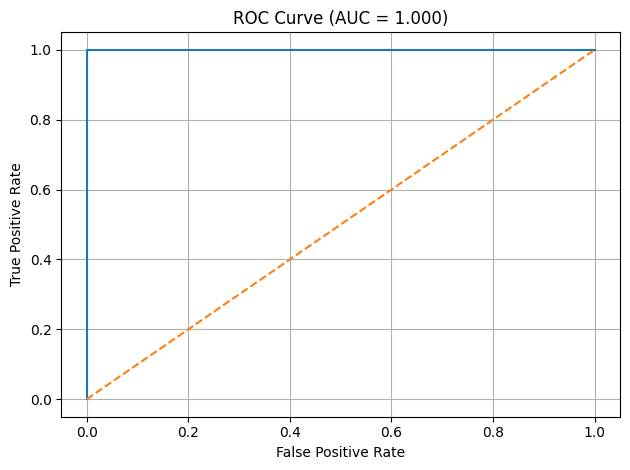

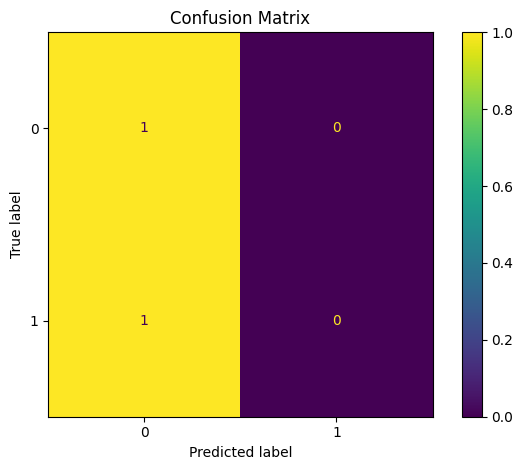

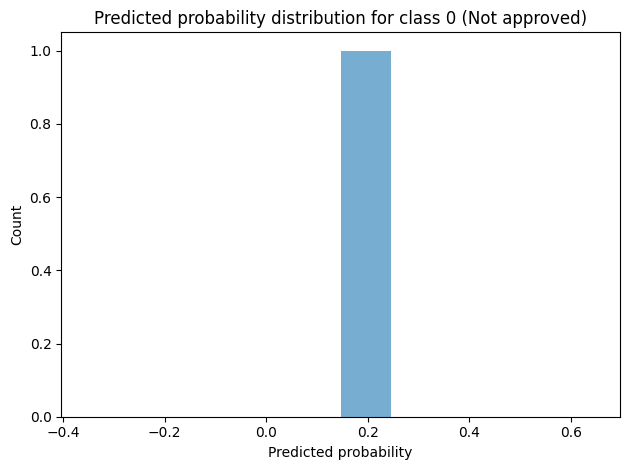

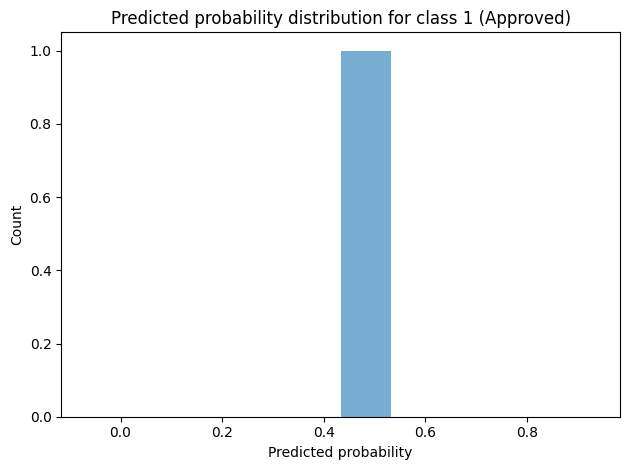

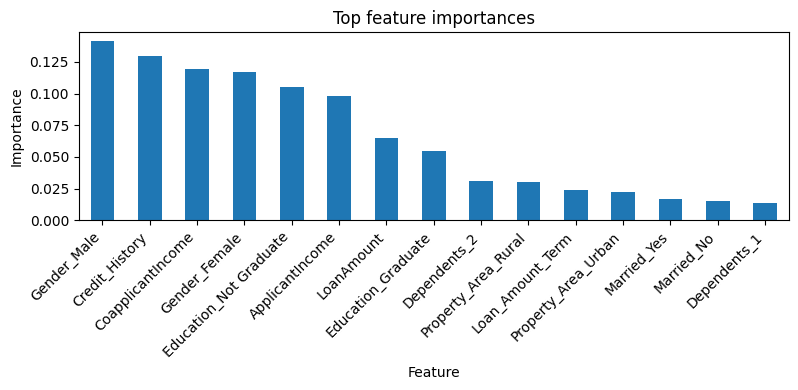

In [ ]:
#@title Matplotlib visualizations for model evaluation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# --- Safety: attempt to recover variables if they don't exist ---
# pipeline, X_test, y_test, y_prob, clf, feature_names expected from previous cells
try:
    pipeline
except NameError:
    import joblib
    pipeline = joblib.load("loan_pipeline_rf.joblib")
    print("Loaded pipeline from loan_pipeline_rf.joblib")

# get test set and predictions if needed
if 'X_test' not in globals() or 'y_test' not in globals():
    # try to reload csv and split (best-effort)
    try:
        df_all = pd.read_csv("loan_data.csv")
        # detect target column name
        tname = next((c for c in df_all.columns if c.lower().startswith("loan_status") or c.lower().startswith("loanstatus")), None)
        if tname is None:
            raise ValueError("Target column not found in loan_data.csv")
        X_all = df_all.drop(columns=[tname])
        y_all = df_all[tname].map({"Y":1,"N":0}) if df_all[tname].dtype == object else df_all[tname]
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)
        print("Recreated X_test and y_test from loan_data.csv (best-effort).")
    except Exception as e:
        raise RuntimeError("X_test/y_test not found and could not reconstruct from loan_data.csv: " + str(e))

# get predicted probabilities if not present
if 'y_prob' not in globals():
    try:
        y_prob = pipeline.predict_proba(X_test)[:,1]
        y_pred = pipeline.predict(X_test)
    except Exception as e:
        raise RuntimeError("Could not compute predictions from pipeline: " + str(e))
else:
    y_pred = pipeline.predict(X_test)

# Attempt to get classifier and feature names
if 'clf' not in globals():
    try:
        clf = pipeline.named_steps['clf']
    except Exception:
        clf = None

# extract feature names after preprocessing if possible
def get_feature_names_from_pipeline(pipe):
    try:
        preproc = pipe.named_steps['preproc']
        # numeric cols
        num_cols = []
        cat_cols = []
        # attempt to find numeric/cat columns from transformers
        for name, trans, cols in preproc.transformers_:
            if name == 'num':
                num_cols = list(cols)
            if name == 'cat':
                cat_cols = list(cols)
        names = []
        if num_cols:
            names.extend(num_cols)
        if cat_cols:
            ohe = preproc.named_transformers_['cat'].named_steps['onehot']
            cat_names = ohe.get_feature_names_out(cat_cols).tolist()
            names.extend(cat_names)
        return names
    except Exception:
        return None

if 'feature_names' not in globals() or not feature_names:
    feature_names = get_feature_names_from_pipeline(pipeline)

# ----------------- Plot 1: ROC Curve -----------------
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.3f})')
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------- Plot 2: Confusion Matrix -----------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
fig, ax = plt.subplots()
disp.plot(ax=ax, values_format='d')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ----------------- Plot 3: Probability distribution histograms -----------------
plt.figure()
plt.hist(y_prob[y_test==0], bins=10, alpha=0.6)
plt.title('Predicted probability distribution for class 0 (Not approved)')
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(y_prob[y_test==1], bins=10, alpha=0.6)
plt.title('Predicted probability distribution for class 1 (Approved)')
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# ----------------- Plot 4: Top feature importances -----------------
if clf is not None and hasattr(clf, "feature_importances_") and feature_names:
    importances = clf.feature_importances_
    # If lengths mismatch, try to trim or label generically
    n_features = min(len(importances), len(feature_names))
    imp_series = pd.Series(importances[:n_features], index=feature_names[:n_features]).sort_values(ascending=False)
    topk = imp_series.head(15)
    plt.figure(figsize=(8, max(4, 0.25*len(topk))))
    topk.plot(kind='bar')
    plt.title('Top feature importances')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances not available (classifier missing or no feature_names).")

